#Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/simpleHTRLine

/content/drive/MyDrive/Colab Notebooks/simpleHTRLine


In [ ]:
%ls

CTCWordBeamSearch/  dump/   src/                 wordRec.ipynb
data/               model/  word_rec_full.ipynb


#Install required libraries

In [ ]:
%pip install path
%pip install typing

     |████████████████████████████████| 81kB 2.6MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-cp37-none-any.whl size=26323 sha256=1217f1fccc2d0407d0c501d823f9f593b4eda741c9ae7bd6cb264d248603cb51
  Stored in directory: /root/.cache/pip/wheels/2d/04/41/8e1836e79581989c22eebac3f4e70aaac9af07b0908da173be
Successfully built typing


In [ ]:
from collections import namedtuple
from typing import Tuple, List
import json
import cv2
import editdistance
from path import Path
import pickle
import random
import numpy as np
import os
import sys
import tensorflow as tf

#DataLoader Class

In [ ]:
Sample = namedtuple('Sample', 'gt_text, file_path')
Batch = namedtuple('Batch', 'imgs, gt_texts, batch_size')


class DataLoaderIAM:
    """
    Loads data which corresponds to IAM format,
    see: http://www.fki.inf.unibe.ch/databases/iam-handwriting-database
    """

    def __init__(self,
                 data_dir: Path,
                 batch_size: int,
                 data_split: float = 0.95,
                 fast: bool = False) -> None:
        """Loader for dataset."""

        #assert data_dir.exists()

        self.fast = fast
        if fast:
            self.env = lmdb.open(str(data_dir / 'lmdb'), readonly=True)

        self.data_augmentation = False
        self.curr_idx = 0
        self.batch_size = batch_size
        self.samples = []

        f = open(data_dir + 'gt/words.txt')
        chars = set()
        bad_samples_reference = ['a01-117-05-02', 'r06-022-03-05']  # known broken images in IAM dataset
        for line in f:
            # ignore comment line
            if not line or line[0] == '#':
                continue

            line_split = line.strip().split(' ')
            assert len(line_split) >= 9

            # filename: part1-part2-part3 --> part1/part1-part2/part1-part2-part3.png
            file_name_split = line_split[0].split('-')
            file_name_subdir1 = file_name_split[0]
            file_name_subdir2 = f'{file_name_split[0]}-{file_name_split[1]}'
            file_base_name = line_split[0] + '.png'
            file_name = data_dir + 'img' + file_name_subdir1 + file_name_subdir2 + file_base_name

            if line_split[0] in bad_samples_reference:
                print('Ignoring known broken image:', file_name)
                continue

            # GT text are columns starting at 9
            gt_text = ' '.join(line_split[8:])
            chars = chars.union(set(list(gt_text)))

            # put sample into list
            self.samples.append(Sample(gt_text, file_name))

        # split into training and validation set: 95% - 5%
        split_idx = int(data_split * len(self.samples))
        self.train_samples = self.samples[:split_idx]
        self.validation_samples = self.samples[split_idx:]

        # put words into lists
        self.train_words = [x.gt_text for x in self.train_samples]
        self.validation_words = [x.gt_text for x in self.validation_samples]

        # start with train set
        self.train_set()

        # list of all chars in dataset
        self.char_list = sorted(list(chars))

    def train_set(self) -> None:
        """Switch to randomly chosen subset of training set."""
        self.data_augmentation = True
        self.curr_idx = 0
        random.shuffle(self.train_samples)
        self.samples = self.train_samples
        self.curr_set = 'train'

    def validation_set(self) -> None:
        """Switch to validation set."""
        self.data_augmentation = False
        self.curr_idx = 0
        self.samples = self.validation_samples
        self.curr_set = 'val'

    def get_iterator_info(self) -> Tuple[int, int]:
        """Current batch index and overall number of batches."""
        if self.curr_set == 'train':
            num_batches = int(np.floor(len(self.samples) / self.batch_size))  # train set: only full-sized batches
        else:
            num_batches = int(np.ceil(len(self.samples) / self.batch_size))  # val set: allow last batch to be smaller
        curr_batch = self.curr_idx // self.batch_size + 1
        return curr_batch, num_batches

    def has_next(self) -> bool:
        """Is there a next element?"""
        if self.curr_set == 'train':
            return self.curr_idx + self.batch_size <= len(self.samples)  # train set: only full-sized batches
        else:
            return self.curr_idx < len(self.samples)  # val set: allow last batch to be smaller

    def _get_img(self, i: int) -> np.ndarray:
        if self.fast:
            with self.env.begin() as txn:
                basename = Path(self.samples[i].file_path).basename()
                data = txn.get(basename.encode("ascii"))
                img = pickle.loads(data)
        else:
            img = cv2.imread(self.samples[i].file_path, cv2.IMREAD_GRAYSCALE)

        return img

    def get_next(self) -> Batch:
        """Get next element."""
        batch_range = range(self.curr_idx, min(self.curr_idx + self.batch_size, len(self.samples)))

        imgs = [self._get_img(i) for i in batch_range]
        gt_texts = [self.samples[i].gt_text for i in batch_range]

        self.curr_idx += self.batch_size
        return Batch(imgs, gt_texts, len(imgs))


#Preprocessor Class

In [ ]:
class Preprocessor:
    def __init__(self,
                 img_size: Tuple[int, int],
                 padding: int = 0,
                 dynamic_width: bool = False,
                 data_augmentation: bool = False,
                 line_mode: bool = False) -> None:
        # dynamic width only supported when no data augmentation happens
        assert not (dynamic_width and data_augmentation)
        # when padding is on, we need dynamic width enabled
        assert not (padding > 0 and not dynamic_width)

        self.img_size = img_size
        self.padding = padding
        self.dynamic_width = dynamic_width
        self.data_augmentation = data_augmentation
        self.line_mode = line_mode

    @staticmethod
    def _truncate_label(text: str, max_text_len: int) -> str:
        """
        Function ctc_loss can't compute loss if it cannot find a mapping between text label and input
        labels. Repeat letters cost double because of the blank symbol needing to be inserted.
        If a too-long label is provided, ctc_loss returns an infinite gradient.
        """
        cost = 0
        for i in range(len(text)):
            if i != 0 and text[i] == text[i - 1]:
                cost += 2
            else:
                cost += 1
            if cost > max_text_len:
                return text[:i]
        return text

    def _simulate_text_line(self, batch: Batch) -> Batch:
        """Create image of a text line by pasting multiple word images into an image."""

        default_word_sep = 30
        default_num_words = 5

        # go over all batch elements
        res_imgs = []
        res_gt_texts = []
        for i in range(batch.batch_size):
            # number of words to put into current line
            num_words = random.randint(1, 8) if self.data_augmentation else default_num_words

            # concat ground truth texts
            curr_gt = ' '.join([batch.gt_texts[(i + j) % batch.batch_size] for j in range(num_words)])
            res_gt_texts.append(curr_gt)

            # put selected word images into list, compute target image size
            sel_imgs = []
            word_seps = [0]
            h = 0
            w = 0
            for j in range(num_words):
                curr_sel_img = batch.imgs[(i + j) % batch.batch_size]
                curr_word_sep = random.randint(20, 50) if self.data_augmentation else default_word_sep
                h = max(h, curr_sel_img.shape[0])
                w += curr_sel_img.shape[1]
                sel_imgs.append(curr_sel_img)
                if j + 1 < num_words:
                    w += curr_word_sep
                    word_seps.append(curr_word_sep)

            # put all selected word images into target image
            target = np.ones([h, w], np.uint8) * 255
            x = 0
            for curr_sel_img, curr_word_sep in zip(sel_imgs, word_seps):
                x += curr_word_sep
                y = (h - curr_sel_img.shape[0]) // 2
                target[y:y + curr_sel_img.shape[0]:, x:x + curr_sel_img.shape[1]] = curr_sel_img
                x += curr_sel_img.shape[1]

            # put image of line into result
            res_imgs.append(target)

        return Batch(res_imgs, res_gt_texts, batch.batch_size)

    def process_img(self, img: np.ndarray) -> np.ndarray:
        """Resize to target size, apply data augmentation."""

        # there are damaged files in IAM dataset - just use black image instead
        if img is None:
            img = np.zeros(self.img_size[::-1])

        # data augmentation
        img = img.astype(np.float)
        if self.data_augmentation:
            # photometric data augmentation
            if random.random() < 0.25:
                def rand_odd():
                    return random.randint(1, 3) * 2 + 1
                img = cv2.GaussianBlur(img, (rand_odd(), rand_odd()), 0)
            if random.random() < 0.25:
                img = cv2.dilate(img, np.ones((3, 3)))
            if random.random() < 0.25:
                img = cv2.erode(img, np.ones((3, 3)))

            # geometric data augmentation
            wt, ht = self.img_size
            h, w = img.shape
            f = min(wt / w, ht / h)
            fx = f * np.random.uniform(0.75, 1.05)
            fy = f * np.random.uniform(0.75, 1.05)

            # random position around center
            txc = (wt - w * fx) / 2
            tyc = (ht - h * fy) / 2
            freedom_x = max((wt - fx * w) / 2, 0)
            freedom_y = max((ht - fy * h) / 2, 0)
            tx = txc + np.random.uniform(-freedom_x, freedom_x)
            ty = tyc + np.random.uniform(-freedom_y, freedom_y)

            # map image into target image
            M = np.float32([[fx, 0, tx], [0, fy, ty]])
            target = np.ones(self.img_size[::-1]) * 255
            img = cv2.warpAffine(img, M, dsize=self.img_size, dst=target, borderMode=cv2.BORDER_TRANSPARENT)

            # photometric data augmentation
            if random.random() < 0.5:
                img = img * (0.25 + random.random() * 0.75)
            if random.random() < 0.25:
                img = np.clip(img + (np.random.random(img.shape) - 0.5) * random.randint(1, 25), 0, 255)
            if random.random() < 0.1:
                img = 255 - img

        # no data augmentation
        else:
            if self.dynamic_width:
                ht = self.img_size[1]
                h, w = img.shape
                f = ht / h
                wt = int(f * w + self.padding)
                wt = wt + (4 - wt) % 4
                tx = (wt - w * f) / 2
                ty = 0
            else:
                wt, ht = self.img_size
                h, w = img.shape
                f = min(wt / w, ht / h)
                tx = (wt - w * f) / 2
                ty = (ht - h * f) / 2

            # map image into target image
            M = np.float32([[f, 0, tx], [0, f, ty]])
            target = np.ones([ht, wt]) * 255
            img = cv2.warpAffine(img, M, dsize=(wt, ht), dst=target, borderMode=cv2.BORDER_TRANSPARENT)

        # transpose for TF
        img = cv2.transpose(img)

        # convert to range [-1, 1]
        img = img / 255 - 0.5
        return img

    def process_batch(self, batch: Batch) -> Batch:
        if self.line_mode:
            batch = self._simulate_text_line(batch)

        res_imgs = [self.process_img(img) for img in batch.imgs]
        max_text_len = res_imgs[0].shape[0] // 4
        res_gt_texts = [self._truncate_label(gt_text, max_text_len) for gt_text in batch.gt_texts]
        return Batch(res_imgs, res_gt_texts, batch.batch_size)

#Tetsing Preprocessor Class

In [ ]:
import matplotlib.pyplot as plt
def test_preprocess(img_path):
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  img_aug = Preprocessor((256, 32), data_augmentation=True).process_img(img)
  plt.subplot(121)
  plt.imshow(img, cmap='gray')
  plt.subplot(122)
  plt.imshow(cv2.transpose(img_aug) + 0.5, cmap='gray', vmin=0, vmax=1)
  plt.show()

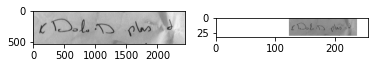

In [ ]:
test_preprocess('/content/drive/MyDrive/Colab Notebooks/simpleHTRLine/data/t16.jpg')

#Model Class

In [ ]:
tf.compat.v1.disable_eager_execution()


class DecoderType:
    """CTC decoder types."""
    BestPath = 0
    BeamSearch = 1
    WordBeamSearch = 2


class Model:
    """Minimalistic TF model for HTR."""

    def __init__(self,
                 char_list: List[str],
                 decoder_type: str = DecoderType.BestPath,
                 must_restore: bool = False,
                 dump: bool = False) -> None:
        """Init model: add CNN, RNN and CTC and initialize TF."""
        self.dump = dump
        self.char_list = char_list
        self.decoder_type = decoder_type
        self.must_restore = must_restore
        self.snap_ID = 0

        # Whether to use normalization over a batch or a population
        self.is_train = tf.compat.v1.placeholder(tf.bool, name='is_train')

        # input image batch
        self.input_imgs = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None))

        # setup CNN, RNN and CTC
        self.setup_cnn()
        self.setup_rnn()
        self.setup_ctc()

        # setup optimizer to train NN
        self.batches_trained = 0
        self.update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(self.update_ops):
            self.optimizer = tf.compat.v1.train.AdamOptimizer().minimize(self.loss)

        # initialize TF
        self.sess, self.saver = self.setup_tf()

    def setup_cnn(self) -> None:
        """Create CNN layers."""
        cnn_in4d = tf.expand_dims(input=self.input_imgs, axis=3)

        # list of parameters for the layers
        kernel_vals = [5, 5, 3, 3, 3]
        feature_vals = [1, 32, 64, 128, 128, 256]
        stride_vals = pool_vals = [(2, 2), (2, 2), (1, 2), (1, 2), (1, 2)]
        num_layers = len(stride_vals)

        # create layers
        pool = cnn_in4d  # input to first CNN layer
        for i in range(num_layers):
            kernel = tf.Variable(
                tf.random.truncated_normal([kernel_vals[i], kernel_vals[i], feature_vals[i], feature_vals[i + 1]],
                                           stddev=0.1))
            conv = tf.nn.conv2d(input=pool, filters=kernel, padding='SAME', strides=(1, 1, 1, 1))
            conv_norm = tf.compat.v1.layers.batch_normalization(conv, training=self.is_train)
            relu = tf.nn.relu(conv_norm)
            pool = tf.nn.max_pool2d(input=relu, ksize=(1, pool_vals[i][0], pool_vals[i][1], 1),
                                    strides=(1, stride_vals[i][0], stride_vals[i][1], 1), padding='VALID')

        self.cnn_out_4d = pool

    def setup_rnn(self) -> None:
        """Create RNN layers."""
        rnn_in3d = tf.squeeze(self.cnn_out_4d, axis=[2])

        # basic cells which is used to build RNN
        num_hidden = 256
        cells = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=num_hidden, state_is_tuple=True) for _ in
                 range(2)]  # 2 layers

        # stack basic cells
        stacked = tf.compat.v1.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=True)

        # bidirectional RNN
        # BxTxF -> BxTx2H
        (fw, bw), _ = tf.compat.v1.nn.bidirectional_dynamic_rnn(cell_fw=stacked, cell_bw=stacked, inputs=rnn_in3d,
                                                                dtype=rnn_in3d.dtype)

        # BxTxH + BxTxH -> BxTx2H -> BxTx1X2H
        concat = tf.expand_dims(tf.concat([fw, bw], 2), 2)

        # project output to chars (including blank): BxTx1x2H -> BxTx1xC -> BxTxC
        kernel = tf.Variable(tf.random.truncated_normal([1, 1, num_hidden * 2, len(self.char_list) + 1], stddev=0.1))
        self.rnn_out_3d = tf.squeeze(tf.nn.atrous_conv2d(value=concat, filters=kernel, rate=1, padding='SAME'),
                                     axis=[2])

    def setup_ctc(self) -> None:
        """Create CTC loss and decoder."""
        # BxTxC -> TxBxC
        self.ctc_in_3d_tbc = tf.transpose(a=self.rnn_out_3d, perm=[1, 0, 2])
        # ground truth text as sparse tensor
        self.gt_texts = tf.SparseTensor(tf.compat.v1.placeholder(tf.int64, shape=[None, 2]),
                                        tf.compat.v1.placeholder(tf.int32, [None]),
                                        tf.compat.v1.placeholder(tf.int64, [2]))

        # calc loss for batch
        self.seq_len = tf.compat.v1.placeholder(tf.int32, [None])
        self.loss = tf.reduce_mean(
            input_tensor=tf.compat.v1.nn.ctc_loss(labels=self.gt_texts, inputs=self.ctc_in_3d_tbc,
                                                  sequence_length=self.seq_len,
                                                  ctc_merge_repeated=True))

        # calc loss for each element to compute label probability
        self.saved_ctc_input = tf.compat.v1.placeholder(tf.float32,
                                                        shape=[None, None, len(self.char_list) + 1])
        self.loss_per_element = tf.compat.v1.nn.ctc_loss(labels=self.gt_texts, inputs=self.saved_ctc_input,
                                                         sequence_length=self.seq_len, ctc_merge_repeated=True)

        # best path decoding or beam search decoding
        if self.decoder_type == DecoderType.BestPath:
            self.decoder = tf.nn.ctc_greedy_decoder(inputs=self.ctc_in_3d_tbc, sequence_length=self.seq_len)
        elif self.decoder_type == DecoderType.BeamSearch:
            self.decoder = tf.nn.ctc_beam_search_decoder(inputs=self.ctc_in_3d_tbc, sequence_length=self.seq_len,
                                                         beam_width=50)
        # word beam search decoding (see https://github.com/githubharald/CTCWordBeamSearch)
        elif self.decoder_type == DecoderType.WordBeamSearch:
            # prepare information about language (dictionary, characters in dataset, characters forming words)
            chars = ''.join(self.char_list)
            word_chars = open('/content/drive/MyDrive/Colab Notebooks/simpleHTRLine/model/wordCharList.txt').read().splitlines()[0]
            corpus = open('/content/drive/MyDrive/Colab Notebooks/simpleHTRLine/data/corpus.txt').read()

            # decode using the "Words" mode of word beam search
            from word_beam_search import WordBeamSearch
            self.decoder = WordBeamSearch(50, 'Words', 0.0, corpus.encode('utf8'), chars.encode('utf8'),
                                          word_chars.encode('utf8'))

            # the input to the decoder must have softmax already applied
            self.wbs_input = tf.nn.softmax(self.ctc_in_3d_tbc, axis=2)

    def setup_tf(self) -> Tuple[tf.compat.v1.Session, tf.compat.v1.train.Saver]:
        """Initialize TF."""
        #print('Python: ' + sys.version)
        #print('Tensorflow: ' + tf.__version__)

        sess = tf.compat.v1.Session()  # TF session

        saver = tf.compat.v1.train.Saver(max_to_keep=1)  # saver saves model to file
        model_dir = '/content/drive/MyDrive/Colab Notebooks/simpleHTRLine/model/'
        latest_snapshot = tf.train.latest_checkpoint(model_dir)  # is there a saved model?

        # if model must be restored (for inference), there must be a snapshot
        if self.must_restore and not latest_snapshot:
            raise Exception('No saved model found in: ' + model_dir)

        # load saved model if available
        if latest_snapshot:
            print('Init with stored values from ' + latest_snapshot)
            saver.restore(sess, latest_snapshot)
        else:
            print('Init with new values')
            sess.run(tf.compat.v1.global_variables_initializer())

        return sess, saver

    def to_sparse(self, texts: List[str]) -> Tuple[List[List[int]], List[int], List[int]]:
        """Put ground truth texts into sparse tensor for ctc_loss."""
        indices = []
        values = []
        shape = [len(texts), 0]  # last entry must be max(labelList[i])

        # go over all texts
        for batchElement, text in enumerate(texts):
            # convert to string of label (i.e. class-ids)
            label_str = [self.char_list.index(c) for c in text]
            # sparse tensor must have size of max. label-string
            if len(label_str) > shape[1]:
                shape[1] = len(label_str)
            # put each label into sparse tensor
            for i, label in enumerate(label_str):
                indices.append([batchElement, i])
                values.append(label)

        return indices, values, shape

    def decoder_output_to_text(self, ctc_output: tuple, batch_size: int) -> List[str]:
        """Extract texts from output of CTC decoder."""

        # word beam search: already contains label strings
        if self.decoder_type == DecoderType.WordBeamSearch:
            label_strs = ctc_output

        # TF decoders: label strings are contained in sparse tensor
        else:
            # ctc returns tuple, first element is SparseTensor
            decoded = ctc_output[0][0]

            # contains string of labels for each batch element
            label_strs = [[] for _ in range(batch_size)]

            # go over all indices and save mapping: batch -> values
            for (idx, idx2d) in enumerate(decoded.indices):
                label = decoded.values[idx]
                batch_element = idx2d[0]  # index according to [b,t]
                label_strs[batch_element].append(label)

        # map labels to chars for all batch elements
        return [''.join([self.char_list[c] for c in labelStr]) for labelStr in label_strs]

    def train_batch(self, batch: Batch) -> float:
        """Feed a batch into the NN to train it."""
        num_batch_elements = len(batch.imgs)
        max_text_len = batch.imgs[0].shape[0] // 4
        sparse = self.to_sparse(batch.gt_texts)
        eval_list = [self.optimizer, self.loss]
        feed_dict = {self.input_imgs: batch.imgs, self.gt_texts: sparse,
                     self.seq_len: [max_text_len] * num_batch_elements, self.is_train: True}
        _, loss_val = self.sess.run(eval_list, feed_dict)
        self.batches_trained += 1
        return loss_val

    @staticmethod
    def dump_nn_output(rnn_output: np.ndarray) -> None:
        """Dump the output of the NN to CSV file(s)."""
        dump_dir = '/content/drive/MyDrive/Colab Notebooks/simpleHTRLine/dump'
        if not os.path.isdir(dump_dir):
            os.mkdir(dump_dir)

        # iterate over all batch elements and create a CSV file for each one
        max_t, max_b, max_c = rnn_output.shape
        for b in range(max_b):
            csv = ''
            for t in range(max_t):
                for c in range(max_c):
                    csv += str(rnn_output[t, b, c]) + ';'
                csv += '\n'
            fn = dump_dir + 'rnnOutput_' + str(b) + '.csv'
            print('Write dump of NN to file: ' + fn)
            with open(fn, 'w') as f:
                f.write(csv)

    def infer_batch(self, batch: Batch, calc_probability: bool = False, probability_of_gt: bool = False):
        """Feed a batch into the NN to recognize the texts."""

        # decode, optionally save RNN output
        num_batch_elements = len(batch.imgs)

        # put tensors to be evaluated into list
        eval_list = []

        if self.decoder_type == DecoderType.WordBeamSearch:
            eval_list.append(self.wbs_input)
        else:
            eval_list.append(self.decoder)

        if self.dump or calc_probability:
            eval_list.append(self.ctc_in_3d_tbc)

        # sequence length depends on input image size (model downsizes width by 4)
        max_text_len = batch.imgs[0].shape[0] // 4

        # dict containing all tensor fed into the model
        feed_dict = {self.input_imgs: batch.imgs, self.seq_len: [max_text_len] * num_batch_elements,
                     self.is_train: False}

        # evaluate model
        eval_res = self.sess.run(eval_list, feed_dict)

        # TF decoders: decoding already done in TF graph
        if self.decoder_type != DecoderType.WordBeamSearch:
            decoded = eval_res[0]
        # word beam search decoder: decoding is done in C++ function compute()
        else:
            decoded = self.decoder.compute(eval_res[0])

        # map labels (numbers) to character string
        texts = self.decoder_output_to_text(decoded, num_batch_elements)

        # feed RNN output and recognized text into CTC loss to compute labeling probability
        probs = None
        if calc_probability:
            sparse = self.to_sparse(batch.gt_texts) if probability_of_gt else self.to_sparse(texts)
            ctc_input = eval_res[1]
            eval_list = self.loss_per_element
            feed_dict = {self.saved_ctc_input: ctc_input, self.gt_texts: sparse,
                         self.seq_len: [max_text_len] * num_batch_elements, self.is_train: False}
            loss_vals = self.sess.run(eval_list, feed_dict)
            probs = np.exp(-loss_vals)

        # dump the output of the NN to CSV file(s)
        if self.dump:
            self.dump_nn_output(eval_res[1])

        return texts, probs

    def save(self) -> None:
        """Save model to file."""
        self.snap_ID += 1
        self.saver.save(self.sess, '../model/snapshot', global_step=self.snap_ID)


#Main Class

In [ ]:
class FilePaths:
    """Filenames and paths to data."""
    fn_char_list = '/content/drive/MyDrive/Colab Notebooks/simpleHTRLine/model/charList.txt'
    fn_summary = '/content/drive/MyDrive/Colab Notebooks/simpleHTRLine/model/summary.json'
    fn_corpus = '/content/drive/MyDrive/Colab Notebooks/simpleHTRLine/data/corpus.txt'

decoder_mapping = {'bestpath': DecoderType.BestPath,
                       'beamsearch': DecoderType.BeamSearch,
                       'wordbeamsearch': DecoderType.WordBeamSearch}
decoder_type = decoder_mapping['bestpath']


def get_img_height() -> int:
    """Fixed height for NN."""
    return 32


def get_img_size(line_mode: bool = False) -> Tuple[int, int]:
    """Height is fixed for NN, width is set according to training mode (single words or text lines)."""
    if line_mode:
        return 256, get_img_height()
    return 128, get_img_height()


def write_summary(char_error_rates: List[float], word_accuracies: List[float]) -> None:
    """Writes training summary file for NN."""
    with open(FilePaths.fn_summary, 'w') as f:
        json.dump({'charErrorRates': char_error_rates, 'wordAccuracies': word_accuracies}, f)


def train(model: Model,
          loader: DataLoaderIAM,
          line_mode: bool,
          early_stopping: int = 25) -> None:
    """Trains NN."""
    epoch = 0  # number of training epochs since start
    summary_char_error_rates = []
    summary_word_accuracies = []
    preprocessor = Preprocessor(get_img_size(line_mode), data_augmentation=True, line_mode=line_mode)
    best_char_error_rate = float('inf')  # best valdiation character error rate
    no_improvement_since = 0  # number of epochs no improvement of character error rate occurred
    # stop training after this number of epochs without improvement
    while True:
        epoch += 1
        print('Epoch:', epoch)

        # train
        print('Train NN')
        loader.train_set()
        while loader.has_next():
            iter_info = loader.get_iterator_info()
            batch = loader.get_next()
            batch = preprocessor.process_batch(batch)
            loss = model.train_batch(batch)
            print(f'Epoch: {epoch} Batch: {iter_info[0]}/{iter_info[1]} Loss: {loss}')

        # validate
        char_error_rate, word_accuracy = validate(model, loader, line_mode)

        # write summary
        summary_char_error_rates.append(char_error_rate)
        summary_word_accuracies.append(word_accuracy)
        write_summary(summary_char_error_rates, summary_word_accuracies)

        # if best validation accuracy so far, save model parameters
        if char_error_rate < best_char_error_rate:
            print('Character error rate improved, save model')
            best_char_error_rate = char_error_rate
            no_improvement_since = 0
            model.save()
        else:
            print(f'Character error rate not improved, best so far: {char_error_rate * 100.0}%')
            no_improvement_since += 1

        # stop training if no more improvement in the last x epochs
        if no_improvement_since >= early_stopping:
            print(f'No more improvement since {early_stopping} epochs. Training stopped.')
            break


def validate(model: Model, loader: DataLoaderIAM, line_mode: bool) -> Tuple[float, float]:
    """Validates NN."""
    print('Validate NN')
    loader.validation_set()
    preprocessor = Preprocessor(get_img_size(line_mode), line_mode=line_mode)
    num_char_err = 0
    num_char_total = 0
    num_word_ok = 0
    num_word_total = 0
    while loader.has_next():
        iter_info = loader.get_iterator_info()
        print(f'Batch: {iter_info[0]} / {iter_info[1]}')
        batch = loader.get_next()
        batch = preprocessor.process_batch(batch)
        recognized, _ = model.infer_batch(batch)

        print('Ground truth -> Recognized')
        for i in range(len(recognized)):
            num_word_ok += 1 if batch.gt_texts[i] == recognized[i] else 0
            num_word_total += 1
            dist = editdistance.eval(recognized[i], batch.gt_texts[i])
            num_char_err += dist
            num_char_total += len(batch.gt_texts[i])
            print('[OK]' if dist == 0 else '[ERR:%d]' % dist, '"' + batch.gt_texts[i] + '"', '->',
                  '"' + recognized[i] + '"')

    # print validation result
    char_error_rate = num_char_err / num_char_total
    word_accuracy = num_word_ok / num_word_total
    print(f'Character error rate: {char_error_rate * 100.0}%. Word accuracy: {word_accuracy * 100.0}%.')
    return char_error_rate, word_accuracy


def infer(model: Model, fn_img: str) -> None:
    """Recognizes text in image provided by file path."""
    img = cv2.imread(fn_img, cv2.IMREAD_GRAYSCALE)
    assert img is not None

    preprocessor = Preprocessor(get_img_size(), dynamic_width=True, padding=16)
    img = preprocessor.process_img(img)

    batch = Batch([img], None, 1)
    recognized, probability = model.infer_batch(batch, True)
    print(f'Recognized: "{recognized[0]}"')
    print(f'Probability: {probability[0]}')
    return recognized, probability

#Testing The Model

In [ ]:
def pred_image(img_path):
  tf.compat.v1.reset_default_graph()
  test_preprocess(img_path)
  model = Model(list(open(FilePaths.fn_char_list).read()), decoder_type, must_restore=True)
  recognized, probability = infer(model, img_path)
  return recognized, probability

#API Part

In [ ]:
!pip install flask-ngrok

In [ ]:
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
import os
import requests
from string import punctuation

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://f331e9e633db.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


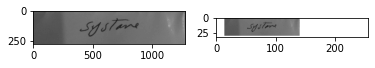

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:308: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:909: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Init with stored values from /content/drive/MyDrive/Colab Notebooks/simpleHTRLine/model/snapshot-13
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Colab Notebooks/simpleHTRLine/model/snapshot-13
Recognized: ",  systonre . I"
Probability: 0.0025889561511576176


127.0.0.1 - - [14/Jul/2021 07:54:01] "POST / HTTP/1.1" 200 -


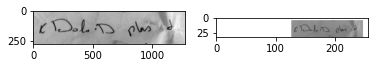

Init with stored values from /content/drive/MyDrive/Colab Notebooks/simpleHTRLine/model/snapshot-13
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Colab Notebooks/simpleHTRLine/model/snapshot-13
Recognized: "fo Doki plasI"
Probability: 0.000555021979380399


127.0.0.1 - - [14/Jul/2021 07:54:58] "POST / HTTP/1.1" 200 -


In [ ]:
app = Flask(__name__)
run_with_ngrok(app)   

def delete_image_after_analysis(img_path):
  os.remove('/content/drive/MyDrive/Colab Notebooks/APIimages/' + img_path)

def compare_texts(recognized_txt, suggestionList):
  output_dict = {}
  for i in range(len(suggestionList)):
    counter = 0
    if len(suggestionList[i]) >= len(recognized_txt):
      for ii in range(len(recognized_txt)):
        if suggestionList[i][ii].lower() == recognized_txt[ii].lower():
           counter += 1
      output_dict[suggestionList[i]] = counter 
    else:
      for ii in range(len(suggestionList[i])):
        if suggestionList[i][ii].lower() == recognized_txt[ii].lower():
           counter += 1
      output_dict[suggestionList[i]] = counter
  return output_dict

def get_suggestions(Recognized_text):
  new_Recognized_text = ''
  num_of_selected_suggestions = 4
  for c in punctuation:
    Recognized_text = Recognized_text.replace(c, '')
  new_Recognized_text = Recognized_text = Recognized_text.strip()
  for chr in new_Recognized_text:
    if chr == ' ':
      new_Recognized_text = new_Recognized_text.replace(chr,'')
  url = f'https://rxnav.nlm.nih.gov/REST/spellingsuggestions.json?name={new_Recognized_text}'
  response = requests.get(url)
  result =response.json()
  if type(result['suggestionGroup']['suggestionList']) == dict:
    suggestionList = result['suggestionGroup']['suggestionList']['suggestion']
    output_string = ''
    myDict = compare_texts(new_Recognized_text, suggestionList)
    if len(myDict) >= num_of_selected_suggestions:
      for i in range(num_of_selected_suggestions):
        MaxDictVal = max(myDict, key=myDict.get)
        output_string += "\t" + MaxDictVal + "\n"
        del myDict[MaxDictVal]
      return f"Recognized text: {new_Recognized_text}\nSuggestion List:\n{output_string}"
    else:
      for i in range(len(myDict)):
        MaxDictVal = max(myDict, key=myDict.get)
        output_string += "\t" + MaxDictVal + "\n"
        del myDict[MaxDictVal]
      return f"Recognized text: {new_Recognized_text}\nSuggestion List:\n{output_string}"
  else:
    return f"Recognized text: {Recognized_text}" 

@app.route("/",methods = ['POST'])
def home():
  image = request.files['image']
  path = image.filename # example.png

  image.save(os.path.join('/content/drive/MyDrive/Colab Notebooks/APIimages/', path))

  Recognized, Probability = pred_image('/content/drive/MyDrive/Colab Notebooks/APIimages/' + path)

  delete_image_after_analysis(path)

  return get_suggestions(Recognized[0])

app.run()